In [1]:
import os
import glob

import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

import cv2
import skimage
from PIL import Image

import matplotlib.pyplot as plt

## Загружаем изображения и gt

In [2]:
images_dir = 'drosophila_kc167_1_images/'
files = sorted(glob.glob(images_dir + '*.TIF'))
X = np.empty((len(files), 512, 512), dtype=np.uint8)

for i, file in enumerate(files):
    X[i] = np.array(Image.open(file))
    
y = pd.read_table('BBBC002_v1_counts.txt').sort_values(by=['file name']).reset_index()

## Визуализируем изображения

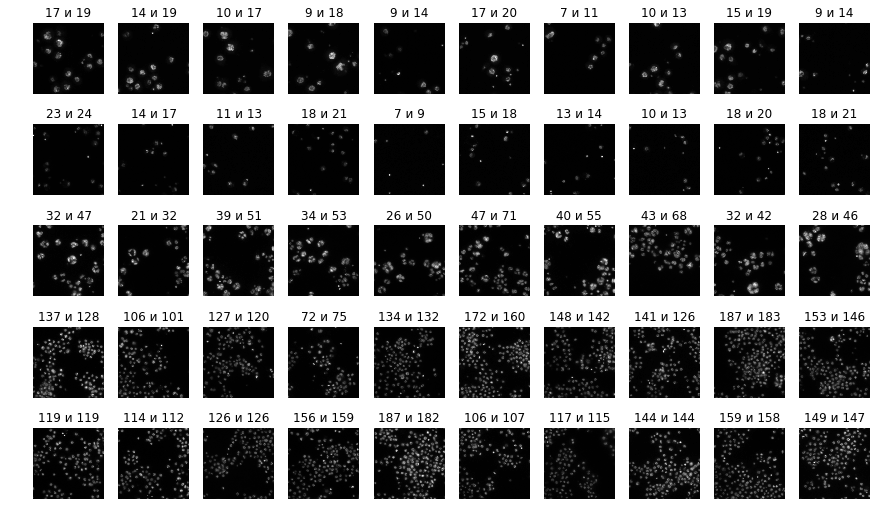

In [3]:
fig = plt.figure(figsize=(15, 9))
columns = 10
rows = 5
for i in range(columns * rows):
    axes = fig.add_subplot(rows, columns, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
    plt.title(
        str(y['human counter 1 (Robert Lindquist)'][i]) + ' и ' + 
        str(y['human counter #2 (Joohan Chang)'][i]))
plt.show()

## Анализируем изображения

In [4]:
import algorithm

#### Извлекаем признаки

In [5]:
X_histogramm = []
X_haralick = []

for x in X:
    X_histogramm.append(algorithm.extract_histogramm_features(x))
    X_haralick.append(algorithm.extract_haralick_features(x))
    
X_histogramm = np.array(X_histogramm)
X_haralick = np.array(X_haralick)

#### Инициализируем модель

In [6]:
normalized_model = Pipeline([('scaler', StandardScaler()), ('model', SVR(gamma='scale'))])

#### Считаем ошибку (признаки по гистограмме)

In [7]:
neg_scores = cross_val_score(
    normalized_model, X=X_histogramm, 
    y=np.log10(y['human counter #2 (Joohan Chang)']), 
    cv=LeaveOneOut(), scoring='neg_mean_absolute_error')
print('Среднее отклонение от логарифма ответа (признаки по гистограмме): %.4f' % np.mean(-neg_scores))

Среднее отклонение от логарифма ответа (признаки по гистограмме): 0.0754


#### Инициализируем модель

In [8]:
normalized_model = Pipeline([('scaler', StandardScaler()), ('model', SVR(gamma='scale'))])

#### Считаем ошибку (признаки Харалика)

In [9]:
neg_scores = cross_val_score(
    normalized_model, X=X_haralick, 
    y=np.log10(y['human counter #2 (Joohan Chang)']), 
    cv=LeaveOneOut(), scoring='neg_mean_absolute_error')
print('Среднее отклонение от логарифма ответа (признаки Харалика): %.4f' % np.mean(-neg_scores))

Среднее отклонение от логарифма ответа (признаки Харалика): 0.0859


## Алгоритм разрастания регионов 

Исходное изображение

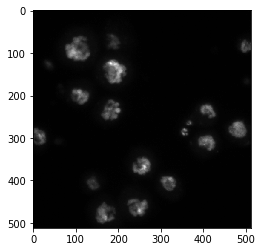

In [10]:
plt.imshow(X[0], cmap='gray')

Запустим алгоритм

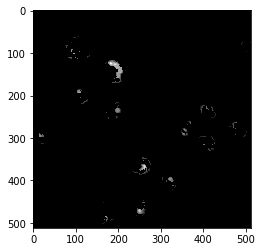

In [11]:
plt.imshow(algorithm.region_growing(X[0], threshold=4), cmap='gray')

Попробуем взять корень от исходного изображения, чтобы сгладить белые участки

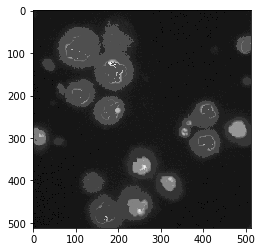

In [12]:
plt.imshow(algorithm.region_growing(X[0].astype(np.float64) ** 0.5, threshold=0.25), cmap='gray')

Попробуем сглаживание с помощью алгоритма закрытия

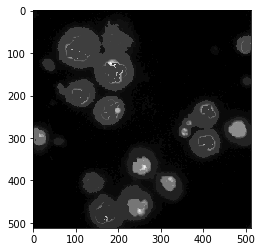

In [13]:
image = algorithm.region_growing(X[0].astype(np.float64) ** 0.5, threshold=0.25)
plt.imshow(cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.ones((3, 3),np.uint8)), cmap='gray')

Попробуем выполнить несколько итераций <b>разрастания - закрытия</b> с увеличивающимся порогом слияния

In [14]:
def growing(image):
    image = image.astype(np.float64) ** 0.5
    threshold=0.25
    for i in range(3):
        image = algorithm.region_growing(image, threshold=threshold)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.ones((3, 3),np.uint8))
        threshold += 0.2
    return image

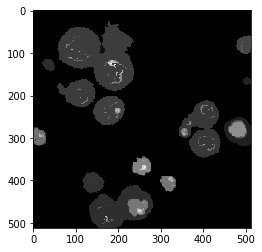

In [15]:
plt.imshow(growing(X[0]), cmap='gray')

### Визуализируем все изображения

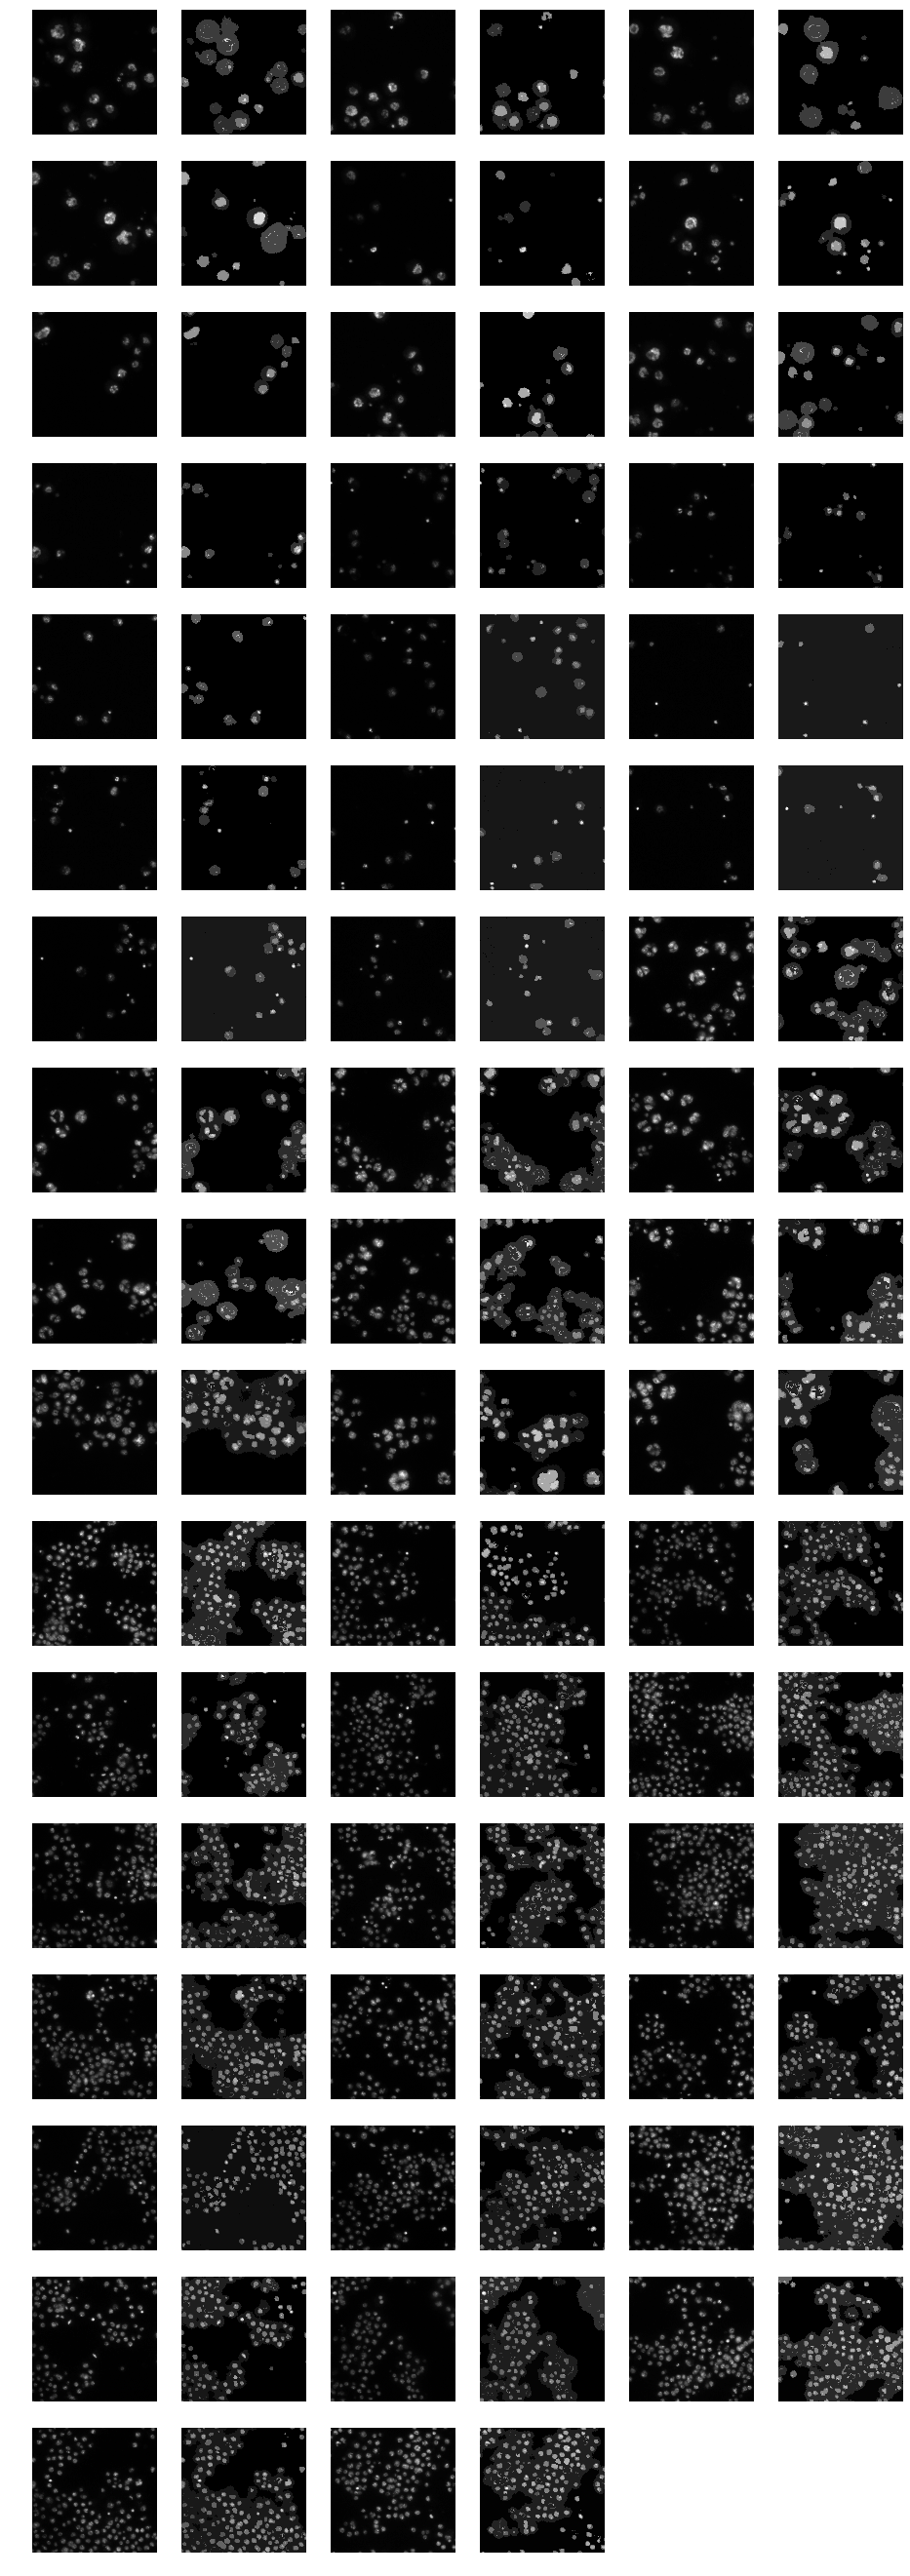

In [16]:
fig = plt.figure(figsize=(16, 48))
columns = 6
rows = 17
for i in range(X.shape[0]):
    axes = fig.add_subplot(rows, columns, 2 * i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
    
    axes = fig.add_subplot(rows, columns, 2 * i + 2)
    plt.imshow(growing(X[i]), cmap='gray')
    plt.axis('off')
plt.show()